In [8]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd

In [9]:
class Network(nn.Module):
    def __init__(self, p1, p2, p3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(31, 70, bias= True),
            nn.SiLU(),
            nn.Linear(70, 70, bias= True),
            nn.SiLU(),
            nn.BatchNorm1d(70),
            nn.Dropout(p = p1),
            nn.Linear(70, 65, bias = True),
            nn.SiLU(),
            nn.Linear(65, 60, bias= True),
            nn.SiLU(),
            nn.Linear(60, 60, bias= True),
            nn.SiLU(),
            nn.BatchNorm1d(60),
            nn.Dropout(p= p2),
            nn.Linear(60, 55, bias= True),
            nn.SiLU(),
            nn.Linear(55, 50, bias= True),
            nn.SiLU(),
            nn.Linear(50, 45, bias= True),
            nn.SiLU(),
            nn.BatchNorm1d(45),
            nn.Dropout(p= p3),
            nn.Linear(45, 40, bias= True),
            nn.SiLU(),
            nn.Linear(40, 35, bias = True),
            nn.SiLU(),
            nn.Linear(35, 25, bias = True),
            nn.SiLU(),
            nn.Linear(25, 20, bias = True),
            nn.SiLU(),
            nn.Linear(20, 15, bias = True),
            nn.SiLU(),
            nn.Linear(15, 10, bias = True),
            nn.SiLU(),
            nn.Linear(10, 5, bias = True)
        )
        self.classify = nn.Sequential(
            nn.Linear(5, 1, bias= True),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.classify(self.features(x))

In [34]:
class Data(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = torch.tensor(x.values, dtype= torch.float32)
        self.y = torch.tensor(y.values, dtype= torch.float32)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, index):
        x, y = self.x[index], self.y[index]
        return x, y

In [35]:
xtrain, ytrain, xtest, ytest = pd.read_csv('./X_train.csv', header= None, index_col = None), pd.read_csv('./y_train.csv', header = None, index_col = None), pd.read_csv('./X_test.csv', header = None, index_col = None), pd.read_csv('./y_test.csv', header = None, index_col = None)
train_data = Data(x= xtrain, y= ytrain)
test_data = Data(x= xtest, y= ytest)
train_loader = DataLoader(train_data, batch_size=100, shuffle= True)
test_loader = DataLoader(test_data, batch_size= 100)

In [13]:
model = Network(0.3, 0.4, 0.5)
model = model.to('cuda')

In [14]:
criterion = nn.BCELoss()
# learning rate decreased by power of 10
optimizer = torch.optim.Adam(model.parameters(), lr = 0.000001, weight_decay= 0.00001)

In [3]:
loss_list_train, loss_list_val = [], []
for epoch in range(200):
    model.train()
    running_loss_trian, running_loss_val = 0.0, 0.0
    for input, target in train_loader:
        input, target = input.to('cuda'), target.to('cuda')
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss_trian += loss.item()
    model.eval()
    with torch.no_grad():
        for input, target in test_loader:
            input, target = input.to('cuda'), target.to('cuda')
            output = torch.round(model(input))
            loss = criterion(output, target)
            running_loss_val += loss.item()
    loss_list_train.append(running_loss_trian / len(train_loader))
    loss_list_val.append(running_loss_val / len(test_loader))
    print(f'Epoch - {epoch} loss - {running_loss_trian}')

NameError: name 'model' is not defined

In [4]:
# made learning rate 0.00001 after 1500 epochs
# 1700 epochs
# lr made 0.000001 after 190 epochs

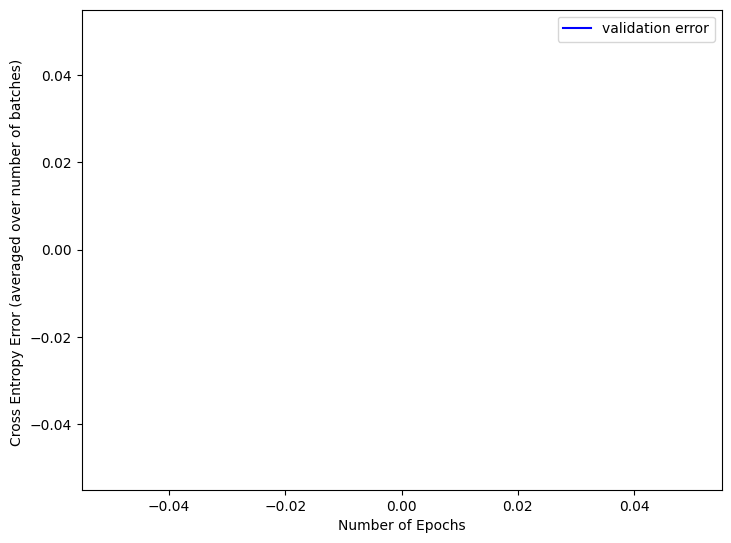

In [5]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# plt.plot(range(len(loss_list_train)), loss_list_train, color= 'red', label = 'training error')
plt.plot(range(len(loss_list_val)), loss_list_val, color = 'blue', label = 'validation error')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Error (averaged over number of batches) ')
plt.legend()
plt.show()

In [36]:
checkpoint = torch.load('best_parameters_silu.pt')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [37]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for input, target in test_loader:
        input, target = input.to('cuda'), target.to('cuda')
        output = torch.round(model(input))
        all_preds.extend(output.to('cpu'))
        all_labels.extend(target.to('cpu'))

from sklearn.metrics import accuracy_score
print(accuracy_score(all_preds, all_labels))


0.7085736806277095


In [38]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
print(recall_score(all_labels, all_preds))
print(precision_score(all_labels, all_preds))
print(f1_score(all_labels, all_preds))

0.548569031416053
0.641292502179599
0.5913178917751093


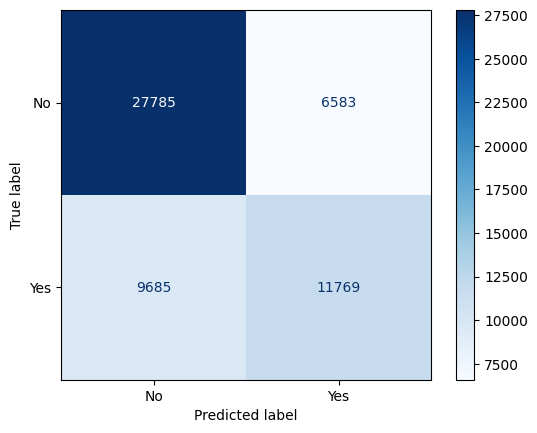

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Example: y_true and y_pred are your ground truth and predictions
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['No', 'Yes'])
disp.plot(cmap='Blues')
plt.show()


In [36]:
import pandas as pd

loss_list_t = pd.read_csv("train_loss_silu_model.csv").values.flatten().tolist()
loss_list_train = loss_list_t + loss_list_train
df = pd.DataFrame(loss_list_train)
df.to_csv("train_loss_silu_model.csv", index=False, header= False)
loss_list_t = pd.read_csv("test_loss_silu_model.csv").values.flatten().tolist()
loss_list_val = loss_list_t + loss_list_val
df = pd.DataFrame(loss_list_val)
df.to_csv("test_loss_silu_model.csv", index= False, header= False)


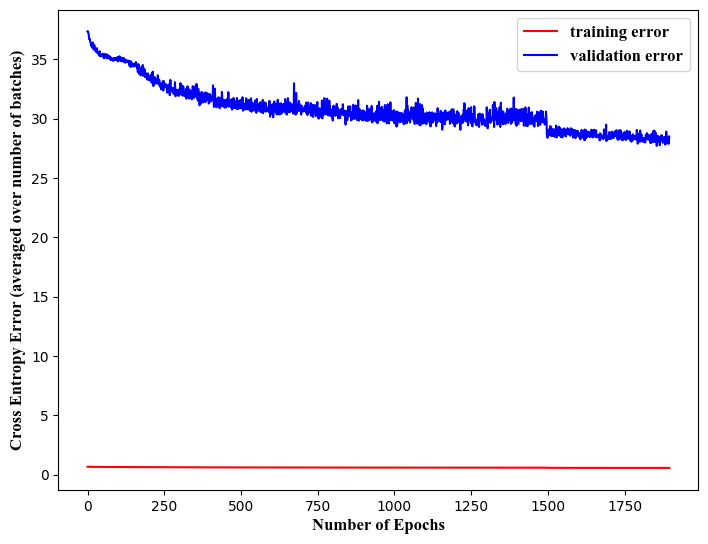

In [42]:
from matplotlib import pyplot as plt
import pandas as pd

# Load loss data
loss_list_train = pd.read_csv("train_loss_silu_model.csv").values.flatten().tolist()
loss_list_test = pd.read_csv("test_loss_silu_model.csv").values.flatten().tolist()

# Create figure
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

# Plotting
plt.plot(range(len(loss_list_train)), loss_list_train, color='red', label='training error')
plt.plot(range(len(loss_list_test)), loss_list_test, color='blue', label='validation error')

# Label styling
font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 12}
plt.xlabel('Number of Epochs', fontdict=font)
plt.ylabel('Cross Entropy Error (averaged over number of batches)', fontdict=font)

# Legend styling
plt.legend(prop={'family': 'Times New Roman', 'weight': 'bold', 'size': 12})

# Show plot
plt.show()
